# Tidio Analiza Sentymentu

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Ładowanie danych

Wczytanie danych to pierwszy krok każdego eksperymentu. Ma on on celu sprowadzenie danych do jednolitej formy, umożliwiającej dalszą obróbkę i analizę.

In [2]:
ratings = pd.read_csv('Data/ratings (1).csv',header=None)

In [3]:
ratings.columns = ['id','target']

In [4]:
ratings.head()

,id,target
0,ttf03feu1hgz1tnmjvtve5unzqb37nna,0
1,ui5s89ofuayahmh695ta7o6q01rhoprt,1
2,sj8z8b38ish20xbttdy670cduy5mcdor,0
3,zholupqqytl7ezi2pu9kgskftsdgvilk,0
4,mygq4r3t0t0mnacop7xqai2amrcnm4fc,1


Plik conversations (1).csv ma w wielu liniach niewłaściwy format - brakuje zamknięcia cydzysłowia. Pandas nie będzie w stanie odczytać tych linii, dlatego trzeba ten plik naprawić zamykając cydzysłów.

In [5]:
with open('Data/conversations (1).csv','r',encoding='utf-8') as f:
    conversations=f.readlines()

In [6]:
for i in range(len(conversations)):
    if conversations[i][-2] != '"':
        conversations[i] = conversations[i][:-1]+'"'+'\n'

In [7]:
with open('Data/conversations_fixed.csv','w',encoding='utf-8') as f:
    f.writelines(conversations)

In [8]:
conversations = pd.read_csv('Data/conversations_fixed.csv',header=None,quotechar='"')

In [9]:
conversations.head()

,0,1,2,3,4,5,6,7,8
0,15590259,5760223,25829,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,chat,visitor,0,1,hello there
1,15590264,5760223,25829,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,chat,operator,85275,1,Hello. This is Matt from Tidio Chat support.
2,15590269,5760223,25829,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,chat,operator,85275,1,Is there anything I can help you with today?
3,15590276,5760223,25829,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,chat,visitor,0,1,Yes
4,15590289,5760223,25829,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,chat,visitor,0,1,Is this chat application for Wordpress?


In [10]:
conversations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22526 entries, 0 to 22525
Data columns (total 9 columns):
0    22526 non-null int64
1    22526 non-null int64
2    22526 non-null int64
3    22526 non-null object
4    22526 non-null object
5    22526 non-null object
6    22526 non-null object
7    22526 non-null int64
8    22523 non-null object
dtypes: int64(4), object(5)
memory usage: 1.5+ MB


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 2 columns):
id        988 non-null object
target    988 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.5+ KB


Wypowiedzi należące do jednego chatu można połączyć w jeden tekst

In [12]:
ids = []
texts=[]

text = conversations[8].values[0]

for i in range(1,len(conversations)):
    if conversations.iloc[i,3] == conversations.iloc[i-1,3]:
        text += ' '+str(conversations.iloc[i,8])
    else:
        ids.append(conversations.iloc[i-1,3])
        texts.append(text)
        text = conversations.iloc[i,8]
ids.append(conversations.iloc[i,3])
texts.append(text)


In [13]:
conversations = pd.DataFrame(zip(ids,texts),columns = ['id','chat'])

In [14]:
conversations.head()

,id,chat
0,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,hello there Hello. This is Matt from Tidio Cha...
1,f5psr203re0d6hesaf3ef8t7vendmont,sonic supersonic d fgtv drew as
2,fblgzoxwvdp4kqxepsri3v89mol5u29h,hi is there any samples ? ???????????? !!!!!!!...
3,ffad9ktpng43ii4t5klj4uvlfge3it79,"kjsdgsshsliheuhue Hi, how can we help you toda..."
4,ffor8fcoz46bxiakuaxewunlgxpj67ur,"women tops Sorry, we don't have women tops mot..."


A następnie połączyć z plikiem ratings (1).csv przyporządkowując każdemu czatowi klasę docelową

In [15]:
dataset = pd.merge(conversations,ratings,on='id',how='left')

In [16]:
dataset.head()

,id,chat,target
0,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,hello there Hello. This is Matt from Tidio Cha...,1.0
1,f5psr203re0d6hesaf3ef8t7vendmont,sonic supersonic d fgtv drew as,0.0
2,fblgzoxwvdp4kqxepsri3v89mol5u29h,hi is there any samples ? ???????????? !!!!!!!...,0.0
3,ffad9ktpng43ii4t5klj4uvlfge3it79,"kjsdgsshsliheuhue Hi, how can we help you toda...",0.0
4,ffor8fcoz46bxiakuaxewunlgxpj67ur,"women tops Sorry, we don't have women tops mot...",0.0


Korzystając z left joina okazało się, że kilkanaście czatów nie ma przyporządkowanej wartości klasy docelowej. Będzie trzeba je usunąć.

In [17]:
dataset[dataset['target'].isna()]

,id,chat,target
40,id80z25aqnvfowosvm6epmmsiyxfv173,Welcome to flycatcher holidays Hi Hi hello can...,NaN
112,n3vzgr7mm2tv9zsp8h74wgdjylwp23k6,"Hi, can i place a order then mail in a check? ...",NaN
124,naue1vidt786aite3v2jynspios5g6yb,This is a test message. This is a test #2. Hel...,NaN
162,nsg5g9xkl8boakx0v1ao1saj8cfr4baj,"Please can you send me more leads? Hello, yes,...",NaN
309,q03lmalrk152ttdi9odfxq5q9z9j89lw,i would like to know if you have a catalog tha...,NaN
394,ravv3pl1oiupbdgqgz4eejaeoj2lbb4n,would i be able to get an email to let me knw ...,NaN
454,s3vi94vd4z1km0bs4rn5jfos3chsbjef,I ordered two of these rings one size 12 and o...,NaN
530,taftw7cgany8h1ug1v5qnjwe7uqom25n,"Hello, good afternoon. I have a question about...",NaN
553,tn7bfaolg8bkkee39m5nd6ph3zqg3qsi,I recently ordered a shirt but I received the ...,NaN
620,ujjt3e2vtdijorm18g7a6iksnnsdqnho,"hello Hello, Hi Darling, I'm Cotton. It's very...",NaN


In [18]:
dataset = dataset.drop(dataset[dataset['target'].isna()].index).reset_index(drop=True)

In [19]:
dataset['target']=dataset['target'].apply(int)

In [20]:
dataset.head()

,id,chat,target
0,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,hello there Hello. This is Matt from Tidio Cha...,1
1,f5psr203re0d6hesaf3ef8t7vendmont,sonic supersonic d fgtv drew as,0
2,fblgzoxwvdp4kqxepsri3v89mol5u29h,hi is there any samples ? ???????????? !!!!!!!...,0
3,ffad9ktpng43ii4t5klj4uvlfge3it79,"kjsdgsshsliheuhue Hi, how can we help you toda...",0
4,ffor8fcoz46bxiakuaxewunlgxpj67ur,"women tops Sorry, we don't have women tops mot...",0


### Czyszczenie

Jeżeli chodzi  o przygotowanie danych do uczenia to w przypadku analizy sentymentu warto wykonać kilka podstawowych czynności takich jak sprowadzenie tekstu do małych liter, usunięcie linków, maili, interpunkcji, liczb oraz tak zwanych stopwordów, które nie mają znaczenia w kontekście wydźwięku wypowiedzi

Sprowadzenie tekstu do małych liter:

In [21]:
dataset['chat'] = dataset['chat'].apply(lambda x: x.lower())

Usunięcie linków i adresów email

In [22]:
def remove_links_emails(text):
    email_regex = "(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
    hyperlink_regex = "(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)"
    text = re.sub(email_regex,'',text)
    text = re.sub(hyperlink_regex,'',text)
    return text

In [23]:
dataset['chat'] = dataset['chat'].apply(remove_links_emails)

Usunięcie punktuacji. Tutaj warto zwrócić uwagę na emotikony, które składają się ze znaków interpunkcyjnych, jednak mogą się one przydać, jako że zazwyczaj mają pozytywny lub negatywny wydźwięk

In [24]:
from string import punctuation

def remove_punct_numbers(text):
    emoticons = [':)',':D',':(',':/']
    word_list = text.split()
    clean =[]
    for word in word_list:
        if word in emoticons:
            clean.append(word)
        else:
            word = re.sub('[^A-Za-z]+', '', word)
            word = ''.join([char for char in word if char not in punctuation])
            if len(word) >0:
                clean.append(word)
    return ' '.join(clean)

In [25]:
dataset['chat'] = dataset['chat'].apply(remove_punct_numbers)

Usunięcie pustych czatów

In [26]:
dataset[dataset['chat'].apply(len)<1]

,id,chat,target
143,nlmfo2hyoqr9f68y7n9kwcd7sdg9gul9,,1


In [27]:
dataset = dataset.drop(dataset[dataset['chat'].apply(len)<1].index).reset_index(drop=True)

In [28]:
dataset.head()

,id,chat,target
0,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,hello there hello this is matt from tidio chat...,1
1,f5psr203re0d6hesaf3ef8t7vendmont,sonic supersonic d fgtv drew as,0
2,fblgzoxwvdp4kqxepsri3v89mol5u29h,hi is there any samples nope sorry we do t dont,0
3,ffad9ktpng43ii4t5klj4uvlfge3it79,kjsdgsshsliheuhue hi how can we help you today...,0
4,ffor8fcoz46bxiakuaxewunlgxpj67ur,women tops sorry we dont have women tops moto ...,0


W treści zadania wyraźnie zaznaczono, że chodzi o język angielski. Warto będzie przefiltrować wszystkie czaty i sprawdzić, czy nie ma w nich wypowiedzi w innych językach, gdyż mogą one wpływać negatywnie na model.

In [29]:
#!pip install langdetect

In [30]:
from langdetect import detect

In [31]:
dataset['lang_detected'] = dataset['chat'].apply(detect)

In [32]:
dataset['lang_detected'].value_counts()

en    913
fr     16
cy     14
pt      7
so      6
pl      4
fi      3
sw      3
no      3
es      3
ca      2
sk      2
sv      2
sl      2
id      2
nl      2
tl      1
sq      1
it      1
Name: lang_detected, dtype: int64

In [34]:
dataset[dataset['lang_detected'] != 'en'].head(10)

,id,chat,target,lang_detected
1,f5psr203re0d6hesaf3ef8t7vendmont,sonic supersonic d fgtv drew as,0,ca
11,fnpw83ose7rrbdxlxq19nodbdk15x6qh,hiiiii any,0,so
18,g8svjzcg179dbwunuoucq7z27w97cxkr,hola buenas tardes encargue una paca desde hac...,0,es
30,h55rfe61t09wpwukvn7yvjq7vts6hzfg,salam salam mene karnaval lazimdir nece eded j...,0,sl
35,hnzfw73rxr4m4d2ktyik8hxohxwoy491,bom dia gostaria de saber se vcs tem loja fisi...,0,pt
49,j6t2woc796awqoneoq71nytepxhmt56u,bonjour jaimerai bien que vous me prouvez que ...,0,fr
60,jwljjmrsb1qa02wovmc9pohqdjv8g7bn,hello how can i help you hello how can i help ...,0,cy
109,n32xa6nmhr78elzhlhjvkw9rs9g4azzi,hi h hi hi hi hi hi hi hi hi hi hi hi hi hih i...,1,it
113,n7a7fgj5lbeavxtdgeghwbmh7dju6pit,hello is there anything i can help you with es...,1,es
119,na97m9b2tn6qc5id3vgg6150i6bbxtej,hej hello there anders creepy isnt it my name ...,1,sv


In [35]:
dataset = dataset.drop(dataset[dataset['lang_detected'] != 'en'].index).reset_index(drop=True)

In [36]:
dataset.head()

,id,chat,target,lang_detected
0,f5ebyhtw9e7yx4d9v00zx1dt21jws0we,hello there hello this is matt from tidio chat...,1,en
1,fblgzoxwvdp4kqxepsri3v89mol5u29h,hi is there any samples nope sorry we do t dont,0,en
2,ffad9ktpng43ii4t5klj4uvlfge3it79,kjsdgsshsliheuhue hi how can we help you today...,0,en
3,ffor8fcoz46bxiakuaxewunlgxpj67ur,women tops sorry we dont have women tops moto ...,0,en
4,ffwo7k7k6f211begodrvj9dud6md74bt,ok is this hoverboard new or used new thanks y...,0,en


Usuwanie stopwordów

In [37]:
#pip install spacy

In [38]:
#!python -m spacy download en_core_web_md

In [39]:
import spacy

In [40]:
nlp = spacy.load('en_core_web_md')

In [41]:
def remove_stopwords(text):
    doc = nlp(text)
    text = ' '.join([token.text for token in doc if not token.is_stop])
    return text

In [42]:
dataset['chat'] = dataset['chat'].apply(remove_stopwords)

### Analiza

Proces Analizy sprowadza się do wykreślenia podstawowych statystyk, najlepiej w podziale na klasy docelowe. Pozwoli to wyłapać wstepne różnice między klasami

Histogram długości czatów w podziale na klasy. Widać, że czaty oznaczone jako negatywne sa zazwyczaj krótsze.

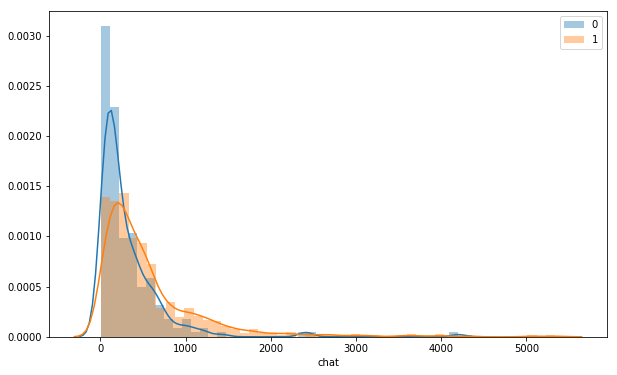

In [43]:
plt.figure(figsize=(10,6))
sns.distplot(dataset[dataset['target']==0]['chat'].apply(len),label=0)
sns.distplot(dataset[dataset['target']==1]['chat'].apply(len),label=1)
plt.legend()

Na histogramie widać długi język biegnący wzdłóż osi x. Oznacza to mnogość czatów które, statystycznie można uznać za wartości odstające, to znaczy nie mieszczące sie między pierwszym a trzecim kwartylem. Lepiej zobrazuje to wykres pudełkowy.

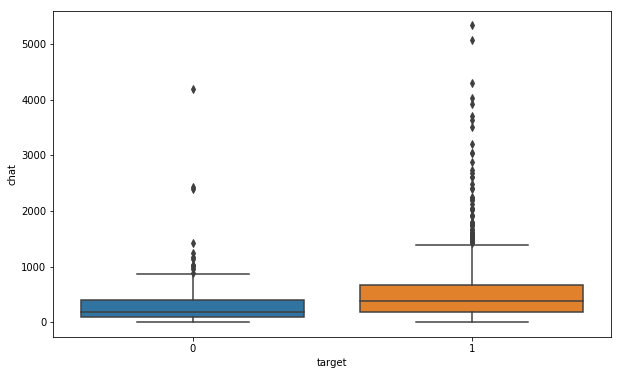

In [44]:
plt.figure(figsize=(10,6))
sns.boxplot(y=dataset['chat'].apply(len),x=dataset['target'])

Podobny histogram mozna wykreślić dla liczby słów w czacie. Widać tutaj, że czaty negatywne mają ich średnio mniej.

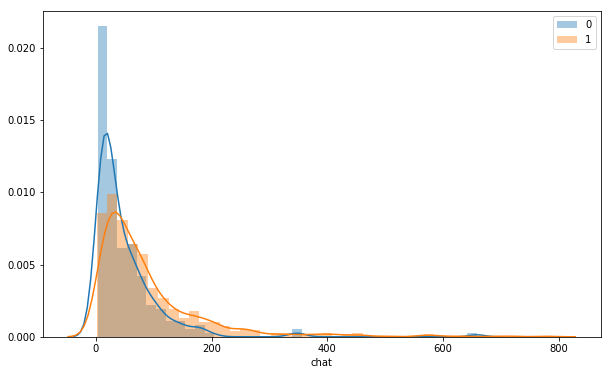

In [45]:
plt.figure(figsize=(10,6))
sns.distplot(dataset[dataset['target']==0]['chat'].apply(lambda x: len(x.split())),label=0)
sns.distplot(dataset[dataset['target']==1]['chat'].apply(lambda x: len(x.split())),label=1)
plt.legend()

Wykres pudełkowy dla liczby słów

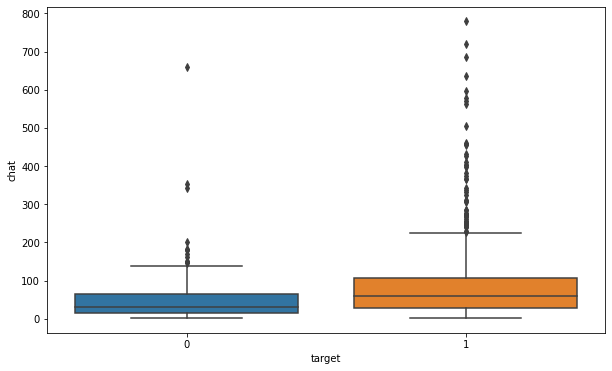

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(y=dataset['chat'].apply(lambda x: len(x.split())),x=dataset['target'])

Aby lepiej poznać strukturę czatów można też sprawdzić najczęściej występujące n-gramy

In [46]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [47]:
text_negative = ' '.join(dataset[dataset['target']==0]['chat'].values)

In [48]:
text_positive = ' '.join(dataset[dataset['target']==1]['chat'].values)

In [49]:
tokens = text_negative.split()
unigrams = ngrams(tokens,1)
bigrams = ngrams(tokens,2)
trigrams = ngrams(tokens,3)

In [50]:
count = Counter(unigrams)

In [51]:
words = []
counts = []
for unigram in count.most_common(20):
    words.append(' '.join(unigram[0]))
    counts.append(unigram[1])

20 najpopularniejszych unigramów klasy negatywnej

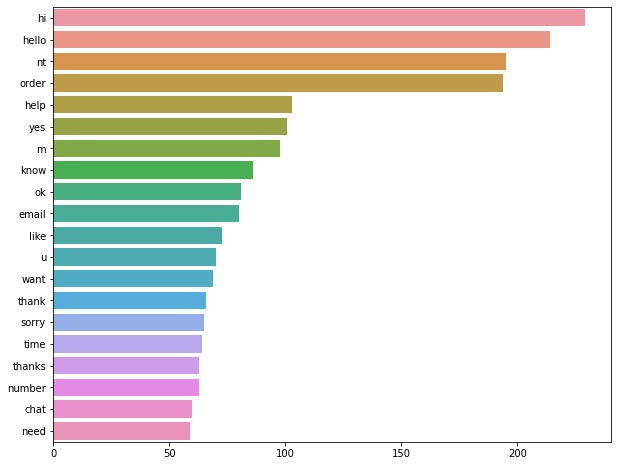

In [52]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

In [53]:
count = Counter(bigrams)

In [54]:
words = []
counts = []
for bigram in count.most_common(20):
    words.append(' '.join(bigram[0]))
    counts.append(bigram[1])

20 najpopularniejszych bigramów klasy negatywnej

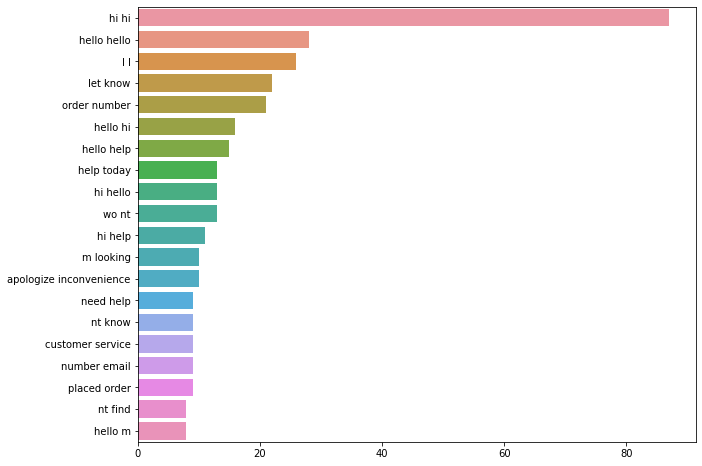

In [55]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

In [56]:
count = Counter(trigrams)

In [57]:
words = []
counts = []
for trigram in count.most_common(20):
    words.append(' '.join(trigram[0]))
    counts.append(trigram[1])

20 najpopularniejszych trigramów klasy negatywnej

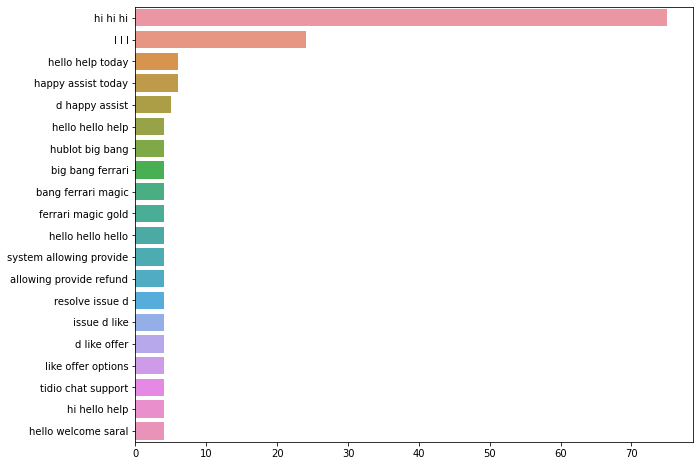

In [58]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

In [59]:
tokens = text_positive.split()
unigrams = ngrams(tokens,1)
bigrams = ngrams(tokens,2)
trigrams = ngrams(tokens,3)

In [60]:
count = Counter(unigrams)

In [61]:
words = []
counts = []
for unigram in count.most_common(20):
    words.append(' '.join(unigram[0]))
    counts.append(unigram[1])

20 najpopularniejszych unigramów klasy pozytywnej

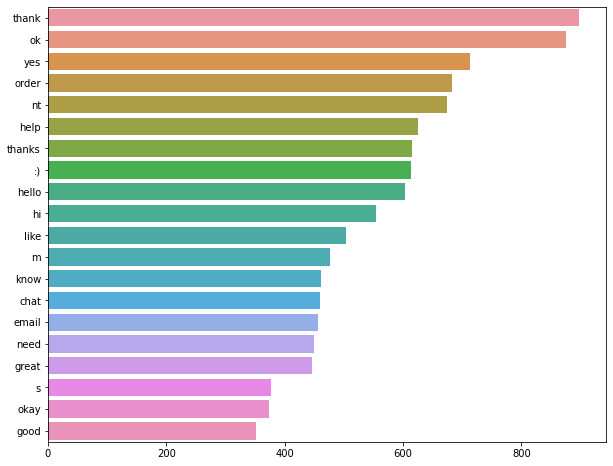

In [62]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

In [63]:
count = Counter(bigrams)

In [64]:
words = []
counts = []
for bigram in count.most_common(20):
    words.append(' '.join(bigram[0]))
    counts.append(bigram[1])

20 najpopularniejszych bigramów klasy pozytywnej

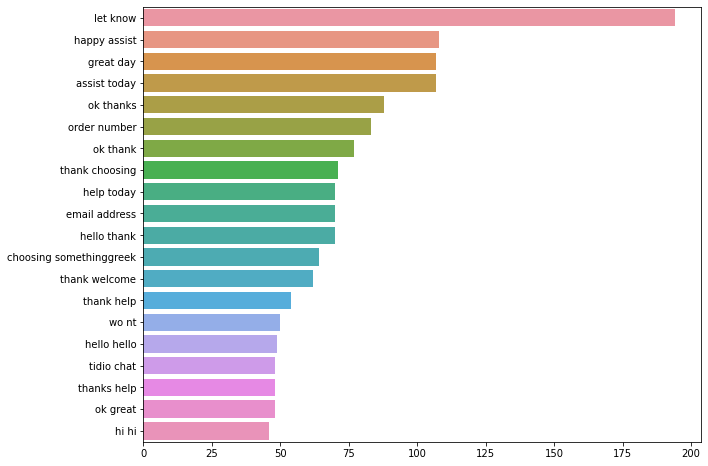

In [65]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

In [66]:
count = Counter(trigrams)

In [67]:
words = []
counts = []
for trigram in count.most_common(20):
    words.append(' '.join(trigram[0]))
    counts.append(trigram[1])

20 najpopularniejszych trigramów klasy pozytywnej

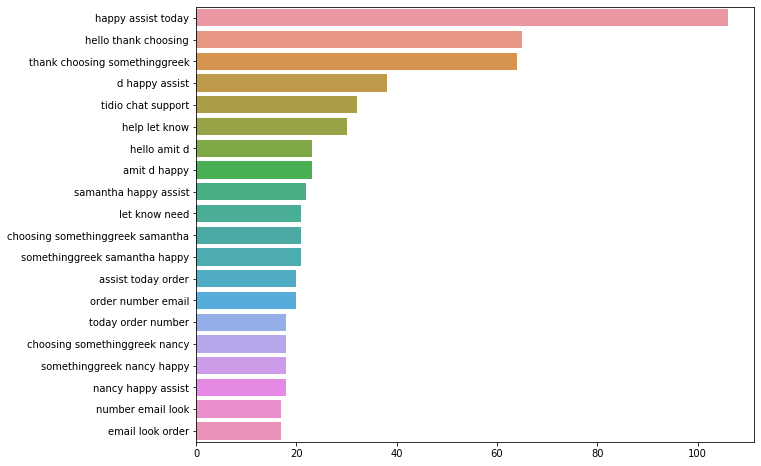

In [68]:
plt.figure(figsize=(10,8))
sns.barplot(y=words,x=counts)

Po analizie n-gramów można zauważyć, że dla klasy negatywnej liczba bigramów i trigramów jest stosunkowo niewielka. Oznacza to, że czaty mają często nieuporządkowaną strukturę (przypadkowe słowa, błędy itd.). Różnicę widać zwłaszcza przy porównaniu z klasą pozytywną. Przy okazji można zauważyć, że jednym z najbardziej popularnym unigramem klasy pozytywnej jest emotka ":)", co oznacza, że decyzja o ich pozostawieniu była poprawna.

### Trening modelu

Po oczyszczeniu danych i wstępnej analizie można spróbować wytrenować model. Większość modeli NLP ma tę wadę, że wymagają wiele danych uczących. W tym przpadku posiadamy nieco ponad 900 czatów, co może być niewystarczające. Warto skoczystac z idei transfer learningu i doszkolić wcześniej wytrenowany model - BERT

Ładowanie modelu

In [70]:
#!pip install transformers

In [71]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Przy okazji analizy danych możana było zauwazyć, że maskymalna długość czatu wynosi ~800 słów jednak trzeci kwartyl klasy pozytywnej kończy się mniej więcej na wartości ~250. Nie ma sensu zatem ustawiać długości maksymalnej sekwencji na wartość 900 - im dłuższa sekwencja tym gorsze uczenie. Wybrano wartość 350 gdyż tokenizacja BERTa polega na rozdzielaniu słów, a więc zwększeniu długości sekwencji.

In [72]:
MAX_LEN = 350

def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in tqdm(data):
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            truncation=True,
            return_attention_mask=True      # Return attention mask
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [73]:
from tqdm import tqdm

In [74]:
#!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [75]:
import torch

In [76]:
if torch.cuda.is_available():       
    device = torch.device("cuda:1")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(1))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 5 GPU(s) available.
Device name: Quadro RTX 6000


In [77]:
X = dataset['chat'].values
y = dataset['target'].values

Liczba klas jest niezbilansowana - każdy model będzie potencjalnie faworyzował klasę większościową. Sumaryczna metryka accuracy będzie pewnie wysoka, jednak recall i precision dla klasy mniejszościowej będą o wiele mniejsze. W tym celu można zastosować dwie techniki - undersampling czyli ucięcie klasy większosciowej lub oversampling czyli generowanie statystycznie podobnych danych uczących klasy mniejszościowej. Biorąc pod uwagę liczbę danych bardziej właściwy będzie oversampling.

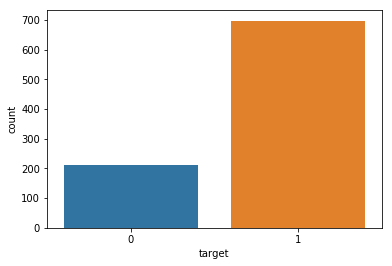

In [46]:
sns.countplot(dataset['target'])

In [78]:
X,_ = preprocessing_for_bert(X)

100%|██████████| 914/914 [00:01<00:00, 658.91it/s]


In [79]:
#pip install imblearn

In [80]:
from imblearn.over_sampling import SMOTE

In [81]:
sm = SMOTE(random_state=42)
X_inputs, y = sm.fit_resample(X, y)

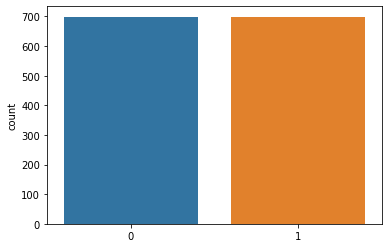

In [82]:
sns.countplot(y)

Przygotowanie danych uczących i walidacyjnych dla BERTa

In [83]:
X_masks = []

for tensor in X_inputs:
    mask = [1 if item > 0 else 0 for item in tensor]
    X_masks.append(mask)

In [84]:
X = []
for i in range(len(X_inputs)):
    X.append((X_inputs[i],X_masks[i]))

In [85]:
#!pip install scikit-learn

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [88]:
train_inputs= []
train_masks = []
for item in X_train:
    train_inputs.append(item[0])
    train_masks.append(item[1])
train_inputs= torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)

val_inputs= []
val_masks = []
for item in X_val:
    val_inputs.append(item[0])
    val_masks.append(item[1])
val_inputs= torch.tensor(val_inputs)
val_masks = torch.tensor(val_masks)

In [89]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Definicja modelu i liczby klas

In [90]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [91]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [92]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [93]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [94]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Pętla ucząca i trening

In [95]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    10  of     38.    Elapsed: 0:00:06.
  Batch    20  of     38.    Elapsed: 0:00:13.
  Batch    30  of     38.    Elapsed: 0:00:19.

  Average training loss: 0.39
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.31
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...
  Batch    10  of     38.    Elapsed: 0:00:07.
  Batch    20  of     38.    Elapsed: 0:00:13.
  Batch    30  of     38.    Elapsed: 0:00:20.

  Average training loss: 0.29
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.26
  Validation took: 0:00:01

Training complete!
Total training took 0:00:52 (h:mm:ss)


### Wnioski

W toku eksperymentu załadowano dane z plików csv, oraz sprowadzono je do wspólnej struktury umożliwiającą dalszą obróbkę. Nastepnie zaproponowano pipeline czyszczenia zawierający sprowadzenie tekstów do małych liter, usunięcie maili i linków, usunięcie stopwordów, usunięcie punktuacji z pominięciem emotikon oraz usunięcie czatów prowadzonych w innych językach niż angielski. W analizie oczyszczonych danych wykazano różnice między klasami oraz otrzymano optymalną długość sekwencji uczącej. Przed uczeniem modelu zastosowano algorytm SMOTE mający zrównać niezbilanoswane klasy. Na koniec trenowania modelu przy pomocy techniki transfer learningu otrzymano sprawność modelu dla danych walidacyjnych na poziomie 91%

Uwagi:

algorytm SMOTE polega na generowaniu danych statystycznie podobnych do tych  w klasie mniejszościowej. Przy otrzymywaniu predykcji dla rzeczywistych danych może jednak okazać się, że recall dla klasy mniejszościowej jest mniejszy niż dla syntetycznych danych testowych. Zasadność stosowania oversampligu pokazuje jednak fakt, że w porównaniu do modelu bez jego zastosowania wartość sprawności na danych walidacyjnych po dwóch epokach wynosiła około 80%. Znaczy to tyle, że model przy obecnym pipelinie i zrównoważonych klasach ma duży potencjał uczący. Rekomendowałbym jednak zrównanie liczby klas danymi rzeczywistymi, jak i zwiększenie zbioru uczącego.